# Analysis
Author: Leon Yin<br>
Date: 2020-2-03<br>

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bs4 import BeautifulSoup
from tqdm import tqdm
import s3
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

## Read the intermediates

In [3]:
data_dir_metadata = '../data/intermediary/google_search/'

In [4]:
metadata_files = glob.glob(
    os.path.join(data_dir_metadata, 'iPhone-X/*/*/*/*/json/parsed_meta.ndjson')
)
len(metadata_files)

14976

## Calculations

In [5]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

\begin{equation}
X_{goog} = \frac{g}{g + o}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + ad}{g + o + ad}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + amp}{g + o + amp}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + amp + ad}{g + o + amp + ad}
\end{equation}

\begin{equation}
X_{goog} = \frac{g}{g + o + amp + ad}
\end{equation}

\begin{equation}
X_{o} = \frac{o}{g + o + amp + ad}
\end{equation}


Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{goog}$: is the percentage of pixels that occupy Google elements.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the total sum of visable pixels occupied by Google links and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the total sum of visable pixels occupied by Organic links.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the total sum of visable pixels occupied by ads.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the total sum of visable pixels occupied by AMP.<br>

In [6]:
def read_file(fn):
    """A json reader, this function allows parallelization"""
    df_merged = pd.read_json(fn, lines=True, orient='records')
    return df_merged.to_dict(orient='records')

In [7]:
n_processes = 12

data = []
with Pool(n_processes) as pool:
    for record in tqdm(pool.imap_unordered(read_file, 
                                           metadata_files), 
                       total=len(metadata_files)):
        data.extend(record)

100%|██████████| 14976/14976 [00:28<00:00, 533.29it/s]


In [8]:
df = pd.DataFrame(data)


text                                  Is Avastin available on NHS?
link                                                          None
domain                                                  google.com
xpath            /html/body/div[10]/div/div[6]/div/div[3]/div/d...
element_class                                       mWyH1d|kno-atc
category                                           answer-expand_2
element                                                        NaN
tag                                                            div
attrs            {'jsname': 'ARU61', 'class': ['mWyH1d', 'kno-a...
dimensions                        {'height': 48.0, 'width': 347.0}
location                                       {'x': 8, 'y': 2857}
area                                                             0
area_page                                                    16656
fn_input         ../data/input/google_search/iPhone-X/2019/11/2...
Name: 0, dtype: object

In [115]:
import json

In [153]:
len(df[~df.element.isnull()])

0

In [150]:
print(json.dumps(df.iloc[-1].to_dict(), indent=2))

{
  "text": "How a Car Works \u203a basics \u203a how-a-...How a diesel engine works | How a Car WorksTraditionally, diesel engines have always been seen as noisy, smelly and underpowered engines of little use other than in trucks, taxis and\u00a0...",
  "link": "https://www.howacarworks.com/basics/how-a-diesel-engine-works",
  "domain": "howacarworks.com",
  "xpath": "/html/body/div[10]/div/div[6]/div/div[3]/div/div[7]/div[2]/div",
  "element_class": "mnr-c|xpd|O9g5cc|uUPGi",
  "category": "organic-search_result",
  "element": NaN,
  "tag": "div",
  "attrs": {
    "class": [
      "mnr-c",
      "xpd",
      "O9g5cc",
      "uUPGi"
    ]
  },
  "dimensions": {
    "height": 225.0,
    "width": 347.0
  },
  "location": {
    "x": 8,
    "y": 4545
  },
  "area": 0.0,
  "area_page": 78075.0,
  "fn_input": "../data/input/google_search/iPhone-X/2020/01/02/Diesel-engine/html/webpage_raw.html",
  "label": "organic",
  "category_standard": "organic"
}


In [9]:
def label_data(category : str):
    """The label is the first word of each category"""
    label = category.split('-')[0]
    return label

In [10]:
df['label'] = df.category.apply(label_data)

In [11]:
df.label.value_counts()

link       634773
answer     224020
organic    219328
amp         79395
ads          4468
Name: label, dtype: int64

In [12]:
len(df)

1161984

## Standardizing categories to be more human readible

In [13]:
cat2catstd = {
    'organic-search_result_1a' : 'organic-search_result',
     'organic-search_result_2a' : 'organic-search_result',
    'organic-search_result_2c': 'organic-search_result',
    'organic-search_result_1b' : 'organic-search_result',
    'organic-search_result_2b': 'organic-search_result',
    'amp-search_result_2' : 'amp-search_result',
    'amp-search_result_1' : 'amp-search_result',
    'organic-tweet_2 ': 'organic-tweet',
    'answer-expand_1' : 'answer-expand',
    'answer-expand_2' :'answer-expand',
    'answer-expand_3' :'answer-expand',
    'link-google_2' : 'link-google',
    'organic-tweet_2' : 'organic-tweet',
    'link-button_2' : 'link-button',
    'answer-knowledge_panel_answer_1' : 'answer-knowledge_panel_answer',
    'answer-knowledge_panel_answer_2' : 'answer-knowledge_panel_answer',
    'answer-date_2' : 'answer-date'
    
}

In [14]:
df.category.replace(cat2catstd, inplace=True)

In [15]:
df.category.value_counts().head(50)

link-google                       308385
answer-knowledge_graph_factoid    105157
organic-search_result             104532
link-img_reverse                  103539
answer-expand                      99095
organic                            93779
link-youtube                       79345
link-button                        60930
link-knowledge_panel_tab           56270
amp-card                           54413
amp-search_result                  24121
organic-tweet                      21017
answer-knowledge_panel_answer      12974
link-load_more                     12528
link-local_people_also_search       2565
link-knowledge_panel_title          1766
ads-google_ad_services              1710
link-topic                          1505
link-google_map                     1361
answer-ugc                          1107
link-video_top_answer               1068
answer-finance_stocks               1008
link-filter                          954
answer-medical                       941
amp-visual_stori

In [16]:
link2subcat = {
    'link-site_search' : 'google-search',
    'link-movie_trailer' : 'google-video',
    'link-video_top_answer' : 'google-video',
    'link-local_google_maps_results' : 'google-maps',
    'link-google_map' : 'google-maps',
    'link-img_reverse' : 'google-images',
    'link-knowledge_panel_tab' : 'google-knowledge-panel-links',
    'link-knowledge_panel_title' : 'google-knowledge-panel-links',
    'link-youtube' : 'google-video'
}

In [17]:
def standardize_category(row):
    '''Logic to assign a standardized category'''
    category = row['category']
    label = row['label']
    
    if label == 'amp':
        subcat = category
    elif label == 'link':
        subcat = link2subcat.get(category, 'google-misc')
    elif label == 'answer':
        if 'expand' in category:
            subcat = 'google-exapandable-answer'
        else:
            subcat = 'google-answer'
    if label in ['organic', 'ads']:
        subcat = label
    return subcat

In [18]:
df['category_standard'] = df.apply(standardize_category, axis=1)

In [19]:
# makethese google search
df.loc[(df.link.str[:9] == '/search?q') &
       (df.label == 'link'), 'category_standard'] = 'google-search'

In [20]:
index2human = {
    'g_over_g_org' : 'E1: g / (g + o)',
    'g_a_over_g_org_a' : 'E2: (g + ad) / (g + o + ad)',
    'g_amp_over_g_org_amp' : 'E3: (g + amp) / (g + o + amp)',
    'g_amp_ad_over_g_org_amp_ad' : 'E4: (g + amp + ad) / (g + o + amp + ad)',
    'g_over_all' : 'E5: g / (g + o + ads + amp)',
}

def various_equations(df, col='area'):
    ad = df[df.label == 'ads'][col].sum()
    amp = df[df.label == 'amp'][col].sum()
    o = df[df.label == 'organic'][col].sum()
    g = df[(df.label == 'link') | 
           (df.label == 'answer')][col].sum()
    data = dict(
        g_over_g_org = g / (g + o),
        g_a_over_g_org_a = (g + ad) / (g + ad + o),
        g_amp_over_g_org_amp = (g + amp) / (g + o + amp + ad),
        g_amp_ad_over_g_org_amp_ad = (g + amp + ad) / (g + o + amp + ad),
        g_over_all = g / (g + ad + o + amp),
    )
    
    data= {index2human.get(k) : v for  k, v in data.items()}
    
    return data

In [21]:
# first-glance
first_glance_perc= various_equations(df, 'area')
first_glance_perc

{'E1: g / (g + o)': 0.7720123783904628,
 'E2: (g + ad) / (g + o + ad)': 0.7889870911636907,
 'E3: (g + amp) / (g + o + amp)': 0.7499842898891196,
 'E4: (g + amp + ad) / (g + o + amp + ad)': 0.8151924394760849,
 'E5: g / (g + o + ads + amp)': 0.6257959240829184}

In [22]:
# full page
full_page_perc = various_equations(df, 'area_page')
full_page_perc

{'E1: g / (g + o)': 0.48096883618089004,
 'E2: (g + ad) / (g + o + ad)': 0.4867257975463684,
 'E3: (g + amp) / (g + o + amp)': 0.5469824750248341,
 'E4: (g + amp + ad) / (g + o + amp + ad)': 0.5565650097682001,
 'E5: g / (g + o + ads + amp)': 0.4109163881496792}

In [23]:
results = pd.DataFrame.from_dict(first_glance_perc, 
                       orient='index', 
                       columns=['area_fg']).join(
    pd.DataFrame.from_dict(full_page_perc, 
                       orient='index', 
                       columns=['area_full']))
results

,area_fg,area_full
E1: g / (g + o),0.772012,0.480969
E2: (g + ad) / (g + o + ad),0.788987,0.486726
E3: (g + amp) / (g + o + amp),0.749984,0.546982
E4: (g + amp + ad) / (g + o + amp + ad),0.815192,0.556565
E5: g / (g + o + ads + amp),0.625796,0.410916


In [24]:
results.mean()

area_fg      0.750394
area_full    0.496432
dtype: float64

In [25]:
# first glance
df.groupby('label') \
  .area.sum() \
  .sort_values(ascending=False) / df.area.sum()

label
link       0.394926
answer     0.230870
organic    0.184808
amp        0.124188
ads        0.065208
Name: area, dtype: float64

In [26]:
# full page
df.groupby('label') \
  .area_page.sum() \
  .sort_values(ascending=False)/ df.area_page.sum()

label
organic    0.443435
link       0.277751
amp        0.136066
answer     0.133166
ads        0.009583
Name: area_page, dtype: float64

## Breakdown of area and frequency for each category

In [27]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(df.area_page.sum()))

cat_area =(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

In [28]:
(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

category_standard
ads                             0.065208
amp-card                        0.118222
amp-search_result               0.003404
amp-visual_stories              0.002563
google-answer                   0.203040
google-exapandable-answer       0.027830
google-images                   0.148503
google-knowledge-panel-links    0.081091
google-maps                     0.014582
google-misc                     0.101553
google-search                   0.029128
google-video                    0.020068
organic                         0.184808
Name: area, dtype: float64

In [31]:
n_pages = df[df.area != 0].fn_input.nunique()

In [32]:
# number of elements on first glance
cat_count = Counter()
for fn, _df in df[df.area != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [33]:
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [34]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [35]:
def breakdown(categories : list(), 
              col='category_standard'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=['area'], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output['area'].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         'area' : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [36]:
columns = [
('Above the fold', 'area')
   ('First glance' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [38]:
total_area = df['area'].sum()
total_area_fp = df['area_page'].sum()
n_pages = df.fn_input.nunique()

In [93]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

In [94]:
data = {}
for label in df.label.unique():
    _df = df[df.label == label]
    area = (_df['area'].sum() / total_area)
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq = _df[_df['area'] != 0].fn_input.nunique() / n_pages
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() /n_pages
    data[label2publabel.get(label,label)] = {
        ('Above the fold', 'area') : area,
        ('Above the fold', 'frequency') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'Frequency') : freq_page,
        
    }

In [123]:
breakdown = pd.DataFrame(data).T
breakdown.columns = pd.MultiIndex.from_tuples([   
    ('Above the fold', 'area'),
    ('Above the fold', 'frequency'),
    ('First page', 'area'),
    ('First page', 'Frequency')
])
(breakdown * 100).round(1).astype(str) + '%'

Above the fold           First page          
                         area frequency       area Frequency
Google Answer           23.1%     66.4%      13.3%     99.4%
Google Product          39.5%     92.4%      27.8%    100.0%
AMP                     12.4%     20.3%      13.6%     80.7%
Organic                 18.5%     74.5%      44.3%    100.0%
Ads                      6.5%      7.9%       1.0%      9.5%

In [147]:
fn_cats = '../data/outputs/T1_area_freq_by_category.csv'
breakdown.to_csv(fn_cats)

In [120]:
# df_cat_agg = pd.DataFrame()
# for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
#     output = breakdown(categories)
#     df_cat_agg = df_cat_agg.append(output)
    
#     output.columns = pd.MultiIndex.from_tuples(columns)
#     for c, dtype in output.dtypes.items():
#         if pd.api.types.is_numeric_dtype(output[c]):
#             output[c] = output[c].apply(format_number)
    
#     display(output)

## Changes in Category between full page of first glance

In [40]:
legend_elements = [Patch(facecolor=cat2color['link'], 
                         label='Google link'),
                   Patch(facecolor=cat2color['answer'], 
                         label='Google answer'),
                   Patch(facecolor=cat2color['amp'], 
                         label='AMP'),
                   Patch(facecolor=cat2color['ads'], 
                         label='Ads'),
                   Patch(facecolor=cat2color['organic'], 
                         label='Organic')]

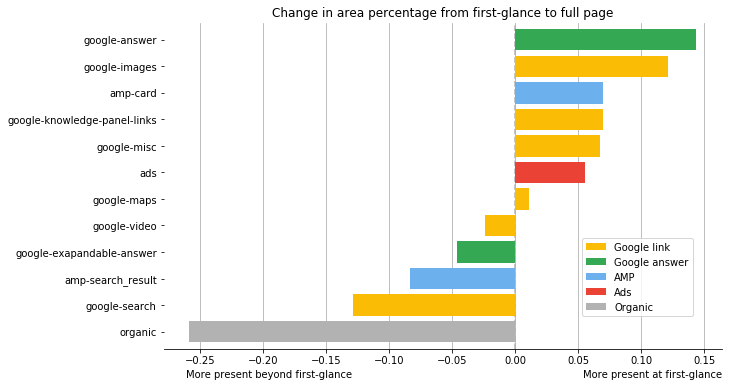

In [42]:
df_cat_agg = df_cat_agg[df_cat_agg.index != 'Total']
df_cat_agg['area_delta'] = df_cat_agg['area'] - df_cat_agg['area_page']
df_plot = df_cat_agg['area_delta'].sort_values(ascending=True)
df_plot = df_plot[abs(df_plot) > .002]
colors = []
for c in df_plot.index:
    if c in cat_ad:
        colors.append(cat2color['ads'])
    elif c in cat_amp:
        colors.append(cat2color['amp'])
    elif c in cat_og:
        colors.append(cat2color['organic'])
    elif c in cat_rt:
        colors.append(cat2color['answer'])
    elif c in cat_sd:
        colors.append(cat2color['link'])
    else:
        colors.append('black')
        
ax = df_plot.plot(kind='barh', 
                  figsize=[10,6],
                  width=.8,
                  color=colors,
                  title='Change in area percentage from first-glance to full page')

plt.axvline(x=0, color='k', linestyle='--', zorder=-1, alpha = .3)

ax.set_axisbelow(True)
plt.gca().xaxis.grid(True)
# plt.gca().yaxis.grid(True)
ax.set_ylabel("")

ax.legend(handles=legend_elements, 
          loc=(.75,.1))

plt.annotate('More present beyond first-glance', 
             (0.04, 0), (0, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')
plt.annotate('More present at first-glance', 
             (.75, 0), (.75, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

## Histogram of Google-occupied pixels

In [154]:
pixels = {
    'area' : [],
    'area_page' : []
}
for search, df_ in tqdm(df.groupby('fn_input')):
    for col in ['area', 'area_page']:
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        g = df_[(df_.label == 'link') | 
                (df_.label == 'answer')][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()

        e1 = g / (g + o)
        
        e2 = (g + ad) / (g + o + ad )
        e3 = (g + amp) / (g + o + amp)
        e4 = (g + amp + ad) / (g + o + amp + ad)
        e5 = g / (g + ad + o + amp)
        
        e6 =  o / (g + ad + o + amp)
        

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
            'e3' : e3,
            'e4' : e4,
            'e5' : e5,
            'e6' : e6
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

100%|██████████| 14976/14976 [01:04<00:00, 232.37it/s]


In [155]:
df_pixels.e1.fillna(0, inplace=True)

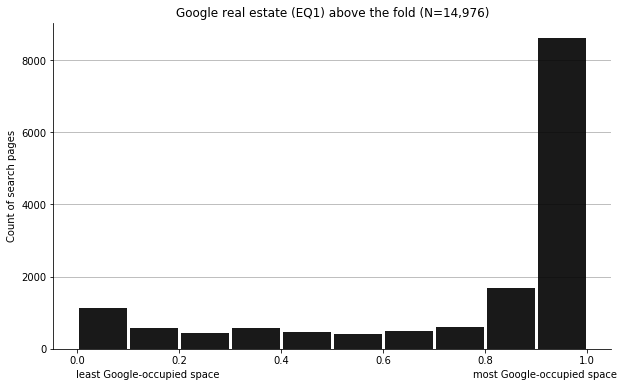

In [125]:
ax = df_pixels.e1.plot(kind='hist', 
                       figsize=(10,6),
                       bins=10, 
                       rwidth=.95,
                       color='black',
                       alpha=.9,
#                        logy=True,
                       title=f'Google real estate (EQ1) above the fold (N={len(df_pixels):,})')

ax.tick_params(axis="both", which="both", bottom="off", 
               top="off", labelbottom="on", left="off", 
               right="off", labelleft="on")

plt.annotate('least Google-occupied space', 
             (0.04, 0), (0, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')
plt.annotate('most Google-occupied space', 
             (.75, 0), (.75, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')

ax.set_ylabel("Count of search pages")

ax.set_axisbelow(True)
plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('../data/e1_above_the_fold.png');

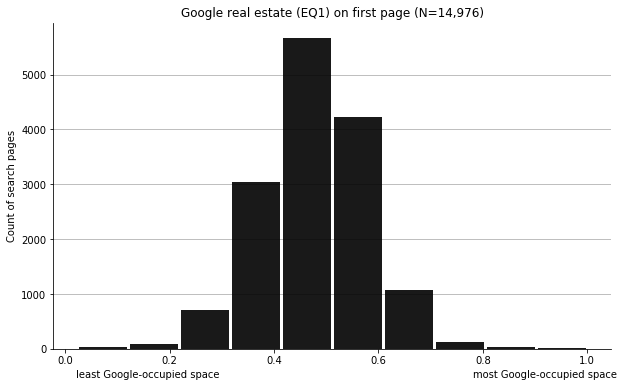

In [126]:
ax = df_pixels_fp.e1.plot(kind='hist', 
                       figsize=(10,6),
                       bins=10, 
                       rwidth=.95,
                       color='black',
                       alpha=.9,
#                        logy=True,
                       title=f'Google real estate (EQ1) on first page (N={len(df_pixels_fp):,})')

ax.tick_params(axis="both", which="both", bottom="off", 
               top="off", labelbottom="on", left="off", 
               right="off", labelleft="on")

plt.annotate('least Google-occupied space', 
             (0.04, 0), (0, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')
plt.annotate('most Google-occupied space', 
             (.75, 0), (.75, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')

ax.set_ylabel("Count of search pages")

ax.set_axisbelow(True)
plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('../data/e1_first_page.png');

In [143]:
# What percentage of pages have 90% or more of the page occupied by self-dealing?
len(df_pixels[df_pixels.e1 >= .9]) / len(df_pixels) * 100

57.47195512820513

In [129]:
# what percentage of pages have less than 10% google
len(df_pixels[df_pixels.e1 == 0]) / len(df_pixels) * 100

4.273504273504273

In [130]:
len(df_pixels)

14976

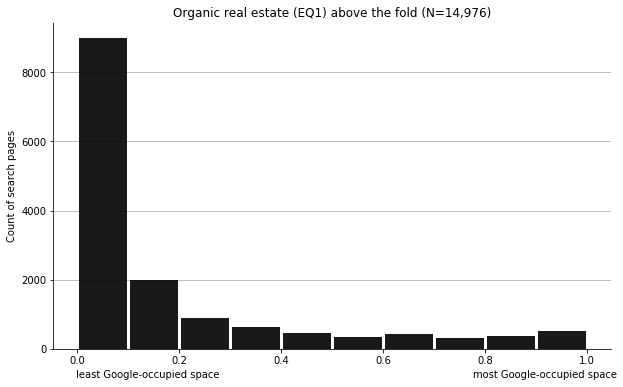

In [140]:
ax = df_pixels.e6.plot(kind='hist', 
                       figsize=(10,6),
                       bins=10, 
                       rwidth=.95,
                       color='black',
                       alpha=.9,
#                        logy=True,
                       title=f'Organic real estate (EQ1) above the fold (N={len(df_pixels):,})')

ax.tick_params(axis="both", which="both", bottom="off", 
               top="off", labelbottom="on", left="off", 
               right="off", labelleft="on")

plt.annotate('least Google-occupied space', 
             (0.04, 0), (0, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')
plt.annotate('most Google-occupied space', 
             (.75, 0), (.75, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')

ax.set_ylabel("Count of search pages")

ax.set_axisbelow(True)
plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# plt.savefig('../data/e1_above_the_fold.png');

In [142]:
# What percentage of pages have 95% or more of the page occupied by self-dealing?
len(df_pixels[df_pixels.e6 <= .1]) / len(df_pixels) * 100

59.99599358974359

## Computing confidence interval

In [131]:
from scipy.stats import t

In [132]:
def t_student_confidence_interval(data, 
                                  confidence = 0.95,
                                  scale = 100):
    n = len(data)
    m = data.mean()
    std_err = data.sem()
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    
    s = f"{scale * m:.2f} ± {h * scale :.2f}"
    return s

In [156]:
index2human = {
    'e1' : 'EQ1: g / (g + o)',
    'e2' : 'EQ2: (g + ad) / (g + o + ad)',
    'e3' : 'EQ3: (g + amp) / (g + o + amp)',
    'e4' : 'EQ4: (g + amp + ad) / (g + o + amp + ad)',
    'e5' : 'EQ5: g / (g + o + ads + amp)',
    
    'e6' : 'EQ6: o / (g + o + ads + amp)',
}

In [157]:
results = {}
for e in [f'e{i}' for i in range(1, 7)]:
    x_goog = t_student_confidence_interval(df_pixels[e])
    x_goog_fp = t_student_confidence_interval(df_pixels_fp[e])
    results[index2human.get(e)] = {
        'above the fold' : x_goog + '%',
        'first page' : x_goog_fp+ '%'
    }

In [158]:
print(pd.DataFrame(results).T.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>above the fold</th>
      <th>first page</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>EQ1: g / (g + o)</th>
      <td>77.27 ± 0.52%</td>
      <td>47.60 ± 0.16%</td>
    </tr>
    <tr>
      <th>EQ2: (g + ad) / (g + o + ad)</th>
      <td>80.33 ± 0.47%</td>
      <td>48.17 ± 0.16%</td>
    </tr>
    <tr>
      <th>EQ3: (g + amp) / (g + o + amp)</th>
      <td>81.08 ± 0.47%</td>
      <td>54.05 ± 0.20%</td>
    </tr>
    <tr>
      <th>EQ4: (g + amp + ad) / (g + o + amp + ad)</th>
      <td>82.78 ± 0.43%</td>
      <td>54.53 ± 0.19%</td>
    </tr>
    <tr>
      <th>EQ5: g / (g + o + ads + amp)</th>
      <td>65.22 ± 0.60%</td>
      <td>40.43 ± 0.13%</td>
    </tr>
    <tr>
      <th>EQ6: o / (g + o + ads + amp)</th>
      <td>17.22 ± 0.43%</td>
      <td>45.47 ± 0.19%</td>
    </tr>
  </tbody>
</table>


SD over EVERYTHING:<br>
65.85%

Just SD over SD + Org:<br>
78%

SD over SD + org + amp:<br>
69.24%

SD + ad over SD + ad +org + amp:<br>
71.31

SD + amp over SD + ad +org + amp:<br>
77.13

O over everything:<br>
17.4

adding or subtracking AMP changes the averfrom from 72% to 81.2% of the page on average. 54% of pages are 95% or more SD (without AMP) and 44% when with AMP.

# AMP
How many sites are using AMP compared to how many sites we have?

In [40]:
from urlexpander import get_domain

n_domains_amp = (df[df.label == 'amp']
                    .link.apply(get_domain)
                    .nunique())

In [41]:
n_domains_og = df[df.label == 'organic'].domain.nunique()

In [42]:
n_domains_amp / (n_domains_amp + n_domains_og)

0.12538671519563238

In [43]:
(df[df.label == 'amp']
    .link.apply(get_domain)
    .value_counts()
    .head(10))

yahoo.com          2330
usatoday.com       1592
people.com         1346
cnbc.com           1137
cbssports.com      1043
theguardian.com     867
foxnews.com         859
nytimes.com         835
cnn.com             804
forbes.com          769
Name: link, dtype: int64

In [44]:
(df[(df.label == 'amp') &
    (df.area != 0)]
    .link.astype(str).apply(get_domain)
    .value_counts()
    .head(10))

yahoo.com        278
google.com       214
people.com       184
usatoday.com     152
espn.com         140
foxnews.com      123
cbssports.com     96
cnn.com           95
nypost.com        69
tmz.com           66
Name: link, dtype: int64

## Organic
How far do you have to go to get an organic link?

In [96]:
blue_link_count = Counter()
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    blue_link_count.update([len(_df[_df.label == 'organic'])])

100%|██████████| 14976/14976 [00:08<00:00, 1859.27it/s]


In [129]:
blue_link_count.most_common()

[(11, 1312),
 (10, 1225),
 (12, 1115),
 (9, 933),
 (13, 902),
 (14, 694),
 (8, 659),
 (15, 519),
 (7, 434),
 (16, 382),
 (6, 268),
 (17, 260),
 (18, 200),
 (5, 138),
 (19, 138),
 (20, 88),
 (4, 67),
 (21, 61),
 (22, 51),
 (3, 23),
 (23, 18),
 (2, 13),
 (24, 10),
 (25, 8),
 (1, 2),
 (26, 1),
 (27, 1),
 (0, 1)]

In [97]:
df[df.label == 'organic'].category.value_counts()

organic-search_result    104532
organic                   93779
organic-tweet             21017
Name: category, dtype: int64

In [98]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [99]:
dist = {}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    y_min = _df[_df.category == 'organic-search_result'].y_dist.min()
    if y_min:
        dist[site] = y_min
        
df_dist = pd.DataFrame([{'page' : k, 'y_dist' : v} for k,v in dist.items()])
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

100%|██████████| 14976/14976 [00:10<00:00, 1375.42it/s]


'1400.87 ± 12.26'

In [104]:
df[df.label == 'organic'].domain.value_counts()

twitter.com            34822
wikipedia.org          29517
facebook.com            7111
instagram.com           5123
imdb.com                4012
                       ...  
urgentteam.com             1
sactownmag.com             1
the-connaught.co.uk        1
milkstudios.com            1
engagevr.io                1
Name: domain, Length: 23936, dtype: int64

In [105]:
df[df.label == 'amp'].domain.value_counts()

yahoo.com               3199
usatoday.com            1825
people.com              1501
cnbc.com                1415
cbssports.com           1352
                        ... 
peepingmoon.com            1
zikanews.com               1
traveldailymedia.com       1
marketbeat.com             1
dailygalaxy.com            1
Name: domain, Length: 3087, dtype: int64

In [86]:
df_dist.y_dist.clip(0, 2000)

0       1940.0
1        956.0
2        891.0
3       1599.0
4        918.0
         ...  
9518    2000.0
9519     919.0
9520    2000.0
9521    1495.0
9522    2000.0
Name: y_dist, Length: 9523, dtype: float64

In [90]:
df_dist = df_dist[~df_dist.y_dist.isnull()]

In [92]:
import math

<BarContainer object of 30 artists>

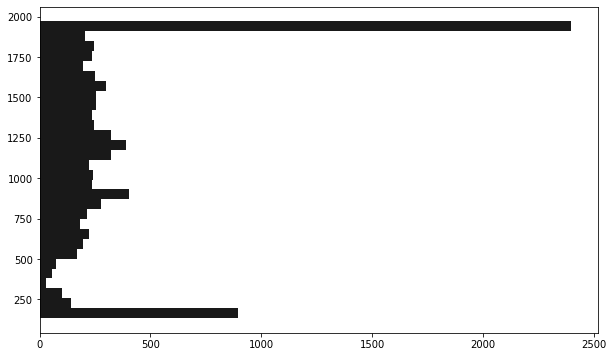

In [100]:
vert_hist=np.histogram(df_dist.y_dist.clip(0, 2000), bins=30)

# Compute height of plot.
height = math.ceil(max(vert_hist[1])) - math.floor(min(vert_hist[1]))

# Compute height of each horizontal bar.
height = height/len(vert_hist[0])

plt.rcParams["figure.figsize"] = (10,6)
plt.barh(vert_hist[1][:-1],vert_hist[0], 
         height=height,
         color='black',
         alpha=.9,)

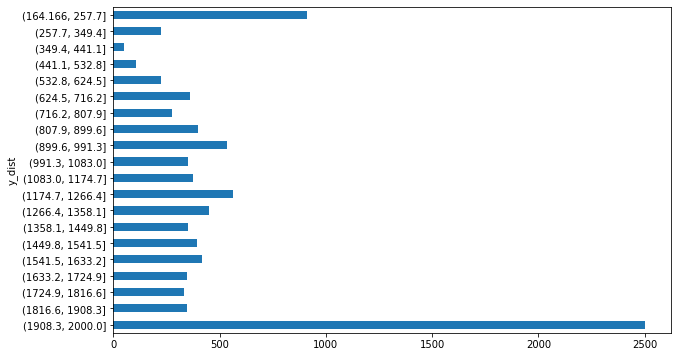

In [115]:
df_dist.groupby(pd.cut(df_dist.y_dist.clip(0, 2000), 20)).size().iloc[::-1].plot(kind='barh')

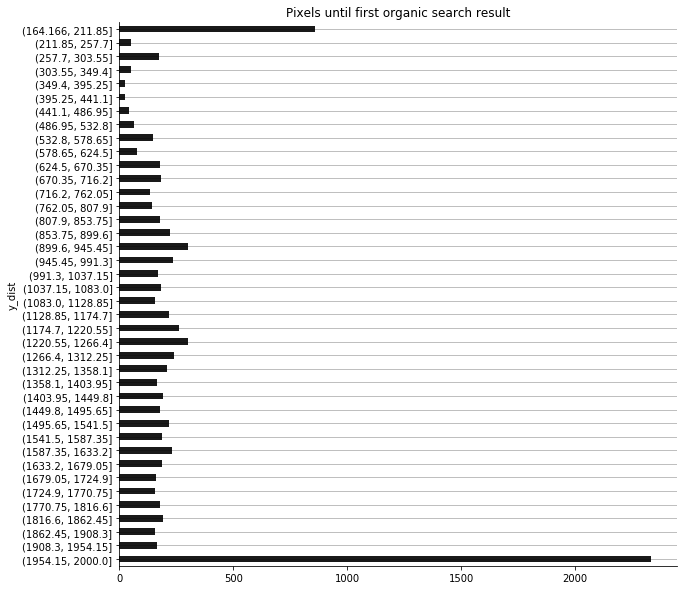

In [124]:
ax = df_dist.groupby(pd.cut(df_dist.y_dist.clip(0, 2000), 40)).size().iloc[::-1].plot(
    kind='barh',
    figsize=(10, 10),
    color='black',
    alpha=.9,
    title='Pixels until first organic search result')


ax.set_axisbelow(True)
plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

In [135]:
result = df_dist.y_dist.value_counts().reset_index()
result.columns = ['y_dist', 'count']
# result['y_dist'] = result['y_dist'].clip(0, 1000)

What percentages of pages have first organic link past the first glance?

What percentages of pages have first organic link past the first glance

In [61]:
df_dist[df_dist['y_dist'] > 812].page.nunique() / n_sample

0.7715005775490916

Average distance before first organic link

In [62]:
df_dist.y_dist.mean()

1399.8468648251235

In [65]:
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

'1399.85 ± 15.42'

In [68]:
dist = {}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    y_min = _df[_df.label == 'organic'].y_dist.min()
    if y_min:
        dist[site] = y_min
        
df_dist = pd.DataFrame([{'page' : k, 'y_dist' : v} for k,v in dist.items()])
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

100%|██████████| 9523/9523 [00:09<00:00, 1045.85it/s]


'662.73 ± 7.32'

In [58]:
organic_down_under = df_dist[df_dist.y_dist > 2500].page

In [59]:
sample = df[(df.fn_input.isin(organic_down_under))
          & (df.category == 'organic-search_result')]

In [60]:
cols = [
    'link',
    'domain',
    'fn_input',
    'y_dist'
]

In [61]:
sample = sample[cols].sort_values(by='y_dist').drop_duplicates(subset=['fn_input'])

In [62]:
sample['search terms'] = sample.fn_input.apply(lambda x: x.split('/')[-3].replace('-', ' '))

In [63]:
sample.to_csv('organic_down_under.csv', index=False)

In [102]:
org = Counter()

In [65]:
for page, _df in sample.groupby('fn_input'):
    _df.sort_values('y_dist', inplace=True)
    org.update([_df.iloc[0].domain])

In [66]:
org.most_common(40)

[('wikipedia.org', 395),
 ('espn.com', 26),
 ('imdb.com', 16),
 ('instagram.com', 11),
 ('basketball-reference.com', 10),
 ('pro-football-reference.com', 8),
 ('nba.com', 6),
 ('mlb.com', 4),
 ('twitter.com', 4),
 ('cdc.gov', 4),
 ('nfl.com', 4),
 ('webmd.com', 4),
 ('fandom.com', 3),
 ('mayoclinic.org', 3),
 ('nih.gov', 3),
 ('goduke.com', 2),
 ('goducks.com', 2),
 ('manchestereveningnews.co.uk', 2),
 ('amazon.com', 2),
 ('nhl.com', 2),
 ('investopedia.com', 2),
 ('cbs.com', 2),
 ('auburntigers.com', 2),
 ('cnet.com', 2),
 ('standard.co.uk', 2),
 ('people.com', 2),
 ('nascar.com', 2),
 ('eliteprospects.com', 2),
 ('hokiesports.com', 2),
 ('pcmag.com', 2),
 ('medlineplus.gov', 2),
 ('ohiostatebuckeyes.com', 2),
 ('rotoworld.com', 2),
 ('microsoft.com', 2),
 ('medicinenet.com', 2),
 ('nasa.gov', 2),
 ('ajax.nl', 1),
 ('dccomics.com', 1),
 ('blakeshelton.com', 1),
 ('gimmedelicious.com', 1)]

In [38]:
df[df['category'] == 'organic-search_result'].domain.value_counts().head(20)

wikipedia.org          5198
twitter.com            1097
facebook.com           1033
imdb.com                996
amazon.com              611
instagram.com           571
espn.com                482
britannica.com          363
fandom.com              359
nih.gov                 333
linkedin.com            316
yahoo.com               268
rottentomatoes.com      251
webmd.com               244
bloomberg.com           222
merriam-webster.com     205
rotoworld.com           202
healthline.com          192
sciencedirect.com       184
mayoclinic.org          166
Name: domain, dtype: int64

In [39]:
df[df['category'] == 'organic'].domain.value_counts().head(20)

wikipedia.org             5009
twitter.com               3543
facebook.com              1418
instagram.com             1275
apple.com                  556
imdb.com                   450
nba.com                    308
spotify.com                291
deezer.com                 284
nbcsports.com              270
iheart.com                 261
pandora.com                247
tunein.com                 223
oxforddictionaries.com     205
nhl.com                    189
cnbc.com                   168
rottentomatoes.com         157
mayoclinic.org             156
linkedin.com               155
cnn.com                    154
Name: domain, dtype: int64

In [41]:
len(df[df['category'] == 'link-youtube'])

27120

In [45]:
df[df['category'] == 'link-youtube'].fn_input.nunique() / df.fn_input.nunique()

0.6614643545279384

In [47]:
len(df[df['category'] == 'link-youtube']) / df[df['category'] == 'link-youtube'].fn_input.nunique()

7.899796096708418

In [ ]:
other_videos = [
    'dailymotion.com',
    'vimeo.com',
    'joyofbaking.com'
]